In [11]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.animation as mpl_animation
from IPython import display

from reading_utils import prepare_contours, load_data, get_contour_tensor
from shape_features import (
    get_gibson_sphericity_index,
    get_sphericity_index,
    get_short_axis,
    get_long_axis,
    get_basal_midpoint,
    get_regional_areas_time,
    convert_to_polar,
    get_cumulative_areas,
    get_triangle_areas,
    get_spacial_heterogeneity_index,
    get_temporal_heterogeneity_index,
    get_region_angles,
    car2pol,
    get_local_ES,
    get_apical_region,
    get_segment_len,
    get_apical_region
)
import pandas as pd

In [2]:
data_path = Path('../../raw_data/datastrain_2023/')
data = load_data(data_path, only_norm=False, only_endo=True)
record_lengths = [len(record['coordinates']) for record in data]
n_frames = max(*record_lengths)

contours = prepare_contours(
    data,
    scale=True,
    center=True,
    interpolate_time_points=n_frames,
    fourier_interpolate_kwargs={'n_harmonics': 6, "n_points_out": None},
    close_contours=False,
)

In [12]:
def get_conicity_index(contour_points):
    # i have to write here the link and that we use the reciprocal. so that closer to 1 is more conical, closer to 0 is less conical
    long_axis = get_long_axis(contour_points)
    long_axis_len = get_segment_len(long_axis)
    long_axis_bound = .5
    short_axis = get_short_axis(contour_points, long_axis=long_axis, la_intersection=long_axis_bound)
    short_axis_len = get_segment_len(short_axis)
    apical_region = get_apical_region(contour_points, short_segment=short_axis)
    apical_region_area = Polygon(apical_region).area
    
    triangle_area = long_axis_bound * long_axis_len * short_axis_len * .5
    
    return triangle_area / apical_region_area

rows = []

for patient in contours:
    contour_points_time = patient['coordinates']
    cis = []
    for frame in contour_points_time:
        ci = get_conicity_index(frame)
        cis.append(ci)
    mean = np.mean(cis)
    std = np.std(cis)
    median = np.median(cis)
    mx = np.max(cis)
    mn = np.min(cis)
    row = [mean, std, median, mx, mn]
    rows.append(row)

column_names = 'mean', 'std', 'median', 'mx', 'mn'

df = pd.DataFrame(rows, columns=column_names)
df.to_csv('conicity.csv')

In [24]:
print('max max', df.mx.argmax())
print('max mean', df['mean'].argmax())
print('max median', df['median'].argmax())
print('min min', df.mn.argmin())
print('min mean', df['mean'].argmin())
print('min median', df['median'].argmin())
print('max std', df['std'].argmax())
print('min std', df['std'].argmin())

max max 73
max mean 73
max median 73
min min 64
min mean 30
min median 1
max std 35
min std 3


In [27]:
def get_eccentricity_index(contour_points):
    long_axis = get_long_axis(contour_points)
    long_axis_len = get_segment_len(long_axis)
    long_axis_bound = .5
    short_axis = get_short_axis(contour_points, long_axis=long_axis, la_intersection=long_axis_bound)
    short_axis_len = get_segment_len(short_axis)
    
    return np.sqrt(long_axis_len ** 2 - short_axis_len ** 2) / long_axis_len

for patient in contours:
    contour_points_time = patient['coordinates']
    cis = []
    for frame in contour_points_time:
        ci = get_eccentricity_index(frame)
        cis.append(ci)
    mean = np.mean(cis)
    std = np.std(cis)
    median = np.median(cis)
    mx = np.max(cis)
    mn = np.min(cis)
    row = [mean, std, median, mx, mn]
    rows.append(row)

column_names = 'mean', 'std', 'median', 'mx', 'mn'

df = pd.DataFrame(rows, columns=column_names)
df.to_csv('eccentricity.csv')

In [30]:
print('max max', df.mx.argmax())
print('max mean', df['mean'].argmax())
print('max median', df['median'].argmax())
print('min min', df.mn.argmin())
print('min mean', df['mean'].argmin())
print('min median', df['median'].argmin())
print('max std', df['std'].argmax())
print('min std', df['std'].argmin())

max max 216
max mean 216
max median 199
min min 116
min mean 116
min median 127
max std 130
min std 3


In [55]:
contour_dir = Path("../../raw_data/Results/")

contours = prepare_contours(
    load_data(contour_dir, only_norm=False),
    scale=True,
    center=True,
    interpolate_time_points=None,
    fourier_interpolate_kwargs=None,
    close_contours=False,
)

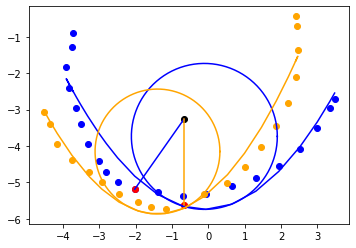

In [206]:
from scipy.optimize import curve_fit

patient = contours[-15]
contour_points_time = patient["coordinates"]
ed_contour = contour_points_time[20]
# plt.scatter(*ed_contour.T, color='blue')
apex_point = ed_contour[len(ed_contour) // 2]
apical_region = get_apical_region(ed_contour, 1 / 3)


# com = np.mean(apical_region, axis=0)
# plt.scatter(*com, color='blue')
# plt.plot([apex_point[0], com[0]], [apex_point[1], com[1]])

com = np.array(list(Polygon(apical_region).centroid.coords)[0])
plt.scatter(*com, color="black")
plt.plot([apex_point[0], com[0]], [apex_point[1], com[1]], color="blue")

orient = np.subtract(com, apex_point)
orient /= np.linalg.norm(orient)
good_orient = np.array([0, 1])
angle = np.arctan2(
    orient[0] * good_orient[1] - orient[1] * good_orient[0],
    orient[0] * good_orient[0] + orient[1] * good_orient[1],
)


def parabola(x, a, b, c):
    return a * x**2 + b * x + c


def parabola_der1(x, a, b, c):
    return 2 * a * x + b


def parabola_der2(x, a, b, c):
    return 2 * a


def curvature_radius(x, f, f_der1, f_der2):
    return (1 + f_der1(x) ** 2) ** (3 / 2) / (f_der2(x))


def curvature_center(x, f, f_der1, f_der2):
    x_c = x - f_der1(x) * (1 + f_der1(x) ** 2) / f_der2(x)
    y_c = f(x) + (1 + f_der1(x) ** 2) / f_der2(x)
    return x_c, y_c


def parabola_curvature_radius(x, a, b, c):
    return curvature_radius(
        x,
        lambda x: parabola(x, a, b, c),
        lambda x: parabola_der1(x, a, b, c),
        lambda x: parabola_der2(x, a, b, c),
    )


def parabola_curvature_center(x, a, b, c):
    return curvature_center(
        x,
        lambda x: parabola(x, a, b, c),
        lambda x: parabola_der1(x, a, b, c),
        lambda x: parabola_der2(x, a, b, c),
    )


x, y = apical_region.T
plt.scatter(*apical_region.T, color="blue")
fit_params, pcov = curve_fit(parabola, x, y)
plt.plot(x, parabola(x, *fit_params), color="blue")


x_min = -fit_params[1] / (2 * fit_params[0])
y_min = parabola(x_min, *fit_params)
point = x_min, y_min
radius = parabola_curvature_radius(point[0], *fit_params)
center = parabola_curvature_center(point[0], *fit_params)
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(
    np.add(center[0], radius * np.cos(theta)),
    np.add(center[1], radius * np.sin(theta)),
    color="blue",
)
plt.scatter(*apex_point, color="red")

rot_matrix = np.array(
    [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
).T
apical_region = get_apical_region(ed_contour, 1 / 3)
apical_region = np.dot(apical_region - com, rot_matrix) + com
apex_point = np.dot(ed_contour - com, rot_matrix)[len(ed_contour) // 2] + com
plt.plot([apex_point[0], com[0]], [apex_point[1], com[1]], color="orange")

x, y = apical_region.T
plt.scatter(*apical_region.T, c="orange")
fit_params, pcov = curve_fit(parabola, x, y)
plt.plot(x, parabola(x, *fit_params), color="orange")

x_min = -fit_params[1] / (2 * fit_params[0])
y_min = parabola(x_min, *fit_params)
point = x_min, y_min
radius = parabola_curvature_radius(point[0], *fit_params)
center = parabola_curvature_center(point[0], *fit_params)
# plt.plot([point[0], center[0]], [parabola(point[0], *fit_params), center[1]], 'orange')
theta = np.linspace(0, 2 * np.pi, 100)
plt.plot(
    np.add(center[0], radius * np.cos(theta)),
    np.add(center[1], radius * np.sin(theta)),
    color="orange",
)
plt.scatter(*apex_point, color="red")


plt.gca().set_aspect("equal")


Method 2b:
Functions calls : f_2b=8 Df_2b=6

Method 3b :  odr with jacobian

Functions calls : f_3b=21 jacb=18 jacd=18

METHOD                    Xc         Yc         Rc         nb_calls   std(Ri)    residu     residu2    
---------------------------------------------------------------------------------------------------
algebraic                 0.04546   -0.67407    3.76668          1   0.111580   0.124500       7.16
leastsq                   0.04059   -0.66101    3.77466         18   0.111435   0.124178       7.18
leastsq with jacobian     0.04059   -0.66101    3.77466          8   0.111435   0.124178       7.18
odr                       0.04059   -0.66101    3.77466        106   0.111435   0.124178       7.18
odr with jacobian         0.04059   -0.66101    3.77466         21   0.111435   0.124178       7.18


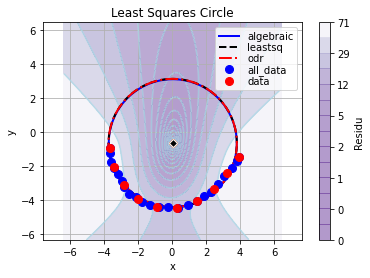

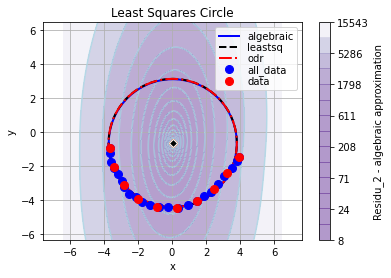

In [46]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

"""
http://www.scipy.org/Cookbook/Least_Squares_Circle
"""

from numpy import *

# Coordinates of the 2D points
from shapely.geometry import LineString

apical_line = LineString(apical_region)
number_of_points = 10
x, y = np.transpose(
    [apical_line.interpolate(t, True).xy for t in np.linspace(0, 1, number_of_points)]
)[0]
# x, y = apical_region.T
# x, y = apical_region[[0,9,-1]].T
# x = np.append(x, np.mean([x[0], x[-1]]))
# y = np.append(y, np.mean([y[0], y[-1]]))

# apical_poly = Polygon(apical_region)
# n_points = 1000
# x, y = np.transpose([apical_poly.exterior.interpolate(t).xy for t in np.linspace(0,apical_poly.length, n_points, False)])[0]
basename = "circle"

# x = r_[36, 36, 19, 18, 33, 26]
# y = r_[14, 10, 28, 31, 18, 26]
# basename = 'arc'

# # Code to generate random data points
# R0 = 25
# nb_pts = 40
# dR = 1
# angle =10*pi/5
# theta0 = random.uniform(0, angle, size=nb_pts)
# x = (10 + R0*cos(theta0) + dR*random.normal(size=nb_pts)).round()
# y = (10 + R0*sin(theta0) + dR*random.normal(size=nb_pts)).round()


# == METHOD 1 ==
method_1 = "algebraic"

# coordinates of the barycenter
x_m = mean(x)
y_m = mean(y)

# calculation of the reduced coordinates
u = x - x_m
v = y - y_m

# linear system defining the center in reduced coordinates (uc, vc):
#    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
#    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
Suv = sum(u * v)
Suu = sum(u**2)
Svv = sum(v**2)
Suuv = sum(u**2 * v)
Suvv = sum(u * v**2)
Suuu = sum(u**3)
Svvv = sum(v**3)

# Solving the linear system
A = array([[Suu, Suv], [Suv, Svv]])
B = array([Suuu + Suvv, Svvv + Suuv]) / 2.0
uc, vc = linalg.solve(A, B)

xc_1 = x_m + uc
yc_1 = y_m + vc

# Calculation of all distances from the center (xc_1, yc_1)
Ri_1 = sqrt((x - xc_1) ** 2 + (y - yc_1) ** 2)
R_1 = mean(Ri_1)
residu_1 = sum((Ri_1 - R_1) ** 2)
residu2_1 = sum((Ri_1**2 - R_1**2) ** 2)

# Decorator to count functions calls
import functools


def countcalls(fn):
    "decorator function count function calls"

    @functools.wraps(fn)
    def wrapped(*args):
        wrapped.ncalls += 1
        return fn(*args)

    wrapped.ncalls = 0
    return wrapped


#  == METHOD 2 ==
# Basic usage of optimize.leastsq
from scipy import optimize

method_2 = "leastsq"


def calc_R(xc, yc):
    """calculate the distance of each 2D points from the center (xc, yc)"""
    return sqrt((x - xc) ** 2 + (y - yc) ** 2)


@countcalls
def f_2(c):
    """calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc)"""
    Ri = calc_R(*c)
    return Ri - Ri.mean()


center_estimate = x_m, y_m
center_2, ier = optimize.leastsq(f_2, center_estimate)

xc_2, yc_2 = center_2
Ri_2 = calc_R(xc_2, yc_2)
R_2 = Ri_2.mean()
residu_2 = sum((Ri_2 - R_2) ** 2)
residu2_2 = sum((Ri_2**2 - R_2**2) ** 2)
ncalls_2 = f_2.ncalls

# == METHOD 2b ==
# Advanced usage, with jacobian
method_2b = "leastsq with jacobian"


def calc_R(xc, yc):
    """calculate the distance of each 2D points from the center c=(xc, yc)"""
    return sqrt((x - xc) ** 2 + (y - yc) ** 2)


@countcalls
def f_2b(c):
    """calculate the algebraic distance between the 2D points and the mean circle centered at c=(xc, yc)"""
    Ri = calc_R(*c)
    return Ri - Ri.mean()


@countcalls
def Df_2b(c):
    """Jacobian of f_2b
    The axis corresponding to derivatives must be coherent with the col_deriv option of leastsq
    """
    xc, yc = c
    df2b_dc = empty((len(c), x.size))

    Ri = calc_R(xc, yc)
    df2b_dc[0] = (xc - x) / Ri  # dR/dxc
    df2b_dc[1] = (yc - y) / Ri  # dR/dyc
    df2b_dc = df2b_dc - df2b_dc.mean(axis=1)[:, newaxis]

    return df2b_dc


center_estimate = x_m, y_m
center_2b, ier = optimize.leastsq(f_2b, center_estimate, Dfun=Df_2b, col_deriv=True)

xc_2b, yc_2b = center_2b
Ri_2b = calc_R(xc_2b, yc_2b)
R_2b = Ri_2b.mean()
residu_2b = sum((Ri_2b - R_2b) ** 2)
residu2_2b = sum((Ri_2b**2 - R_2b**2) ** 2)
ncalls_2b = f_2b.ncalls

print("\nMethod 2b:")
print("Functions calls : f_2b={:d} Df_2b={:d}" "".format(f_2b.ncalls, Df_2b.ncalls))

# == METHOD 3 ==
# Basic usage of odr with an implicit function definition
from scipy import odr

method_3 = "odr"


@countcalls
def f_3(beta, x):
    """implicit definition of the circle"""
    return (x[0] - beta[0]) ** 2 + (x[1] - beta[1]) ** 2 - beta[2] ** 2


# initial guess for parameters
R_m = calc_R(x_m, y_m).mean()
beta0 = [x_m, y_m, R_m]

# for implicit function :
#       data.x contains both coordinates of the points
#       data.y is the dimensionality of the response
lsc_data = odr.Data(row_stack([x, y]), y=1)
lsc_model = odr.Model(f_3, implicit=True)
lsc_odr = odr.ODR(lsc_data, lsc_model, beta0)
lsc_out = lsc_odr.run()

xc_3, yc_3, R_3 = lsc_out.beta
Ri_3 = calc_R(xc_3, yc_3)
residu_3 = sum((Ri_3 - R_3) ** 2)
residu2_3 = sum((Ri_3**2 - R_3**2) ** 2)
ncalls_3 = f_3.ncalls

# == METHOD 3b ==
# Advanced usage, with jacobian
method_3b = "odr with jacobian"
print("\nMethod 3b : ", method_3b)


@countcalls
def f_3b(beta, x):
    """implicit definition of the circle"""
    return (x[0] - beta[0]) ** 2 + (x[1] - beta[1]) ** 2 - beta[2] ** 2


@countcalls
def jacb(beta, x):
    """Jacobian function with respect to the parameters beta.
    return df_3b/dbeta
    """
    xc, yc, r = beta
    xi, yi = x

    df_db = empty((beta.size, x.shape[1]))
    df_db[0] = 2 * (xc - xi)  # d_f/dxc
    df_db[1] = 2 * (yc - yi)  # d_f/dyc
    df_db[2] = -2 * r  # d_f/dr

    return df_db


@countcalls
def jacd(beta, x):
    """Jacobian function with respect to the input x.
    return df_3b/dx
    """
    xc, yc, r = beta
    xi, yi = x

    df_dx = empty_like(x)
    df_dx[0] = 2 * (xi - xc)  # d_f/dxi
    df_dx[1] = 2 * (yi - yc)  # d_f/dyi

    return df_dx


def calc_estimate(data):
    """Return a first estimation on the parameter from the data"""
    xc0, yc0 = data.x.mean(axis=1)
    r0 = sqrt((data.x[0] - xc0) ** 2 + (data.x[1] - yc0) ** 2).mean()
    return xc0, yc0, r0


# for implicit function :
#       data.x contains both coordinates of the points
#       data.y is the dimensionality of the response
lsc_data = odr.Data(row_stack([x, y]), y=1)
lsc_model = odr.Model(
    f_3b, implicit=True, estimate=calc_estimate, fjacd=jacd, fjacb=jacb
)
lsc_odr = odr.ODR(
    lsc_data, lsc_model
)  # beta0 has been replaced by an estimate function
lsc_odr.set_job(deriv=3)  # use user derivatives function without checking
lsc_odr.set_iprint(iter=1, iter_step=1)  # print details for each iteration
lsc_out = lsc_odr.run()

xc_3b, yc_3b, R_3b = lsc_out.beta
Ri_3b = calc_R(xc_3b, yc_3b)
residu_3b = sum((Ri_3b - R_3b) ** 2)
residu2_3b = sum((Ri_3b**2 - R_3b**2) ** 2)
ncalls_3b = f_3b.ncalls

print(
    "\nFunctions calls : f_3b={:d} jacb={:d} jacd={:d}".format(
        f_3b.ncalls, jacb.ncalls, jacd.ncalls
    )
)


# Summary
fmt = "{:22s} {:10.5f} {:10.5f} {:10.5f} {:10d} {:10.6f} {:10.6f} {:10.2f}"
fmt2 = "\n{:22s}    " + "{:10s} " * 7
_names = "METHOD Xc Yc Rc nb_calls std(Ri) residu residu2".split()
print(fmt2.format(*_names))
print("-" * (22 + 7 * (10 + 1)))
print(fmt.format(method_1, xc_1, yc_1, R_1, 1, Ri_1.std(), residu_1, residu2_1))
print(fmt.format(method_2, xc_2, yc_2, R_2, ncalls_2, Ri_2.std(), residu_2, residu2_2))
print(
    fmt.format(
        method_2b, xc_2b, yc_2b, R_2b, ncalls_2b, Ri_2b.std(), residu_2b, residu2_2b
    )
)
print(fmt.format(method_3, xc_3, yc_3, R_3, ncalls_3, Ri_3.std(), residu_3, residu2_3))
print(
    fmt.format(
        method_3b, xc_3b, yc_3b, R_3b, ncalls_3b, Ri_3b.std(), residu_3b, residu2_3b
    )
)

# plotting functions
from matplotlib import pyplot as p, cm, colors

p.close("all")


def plot_all(residu2=False):
    """Draw data points, best fit circles and center for the three methods,
    and adds the iso contours corresponding to the fiel residu or residu2
    """

    f = p.figure(facecolor="white")  # figsize=(7, 5.4), dpi=72,
    p.axis("equal")

    theta_fit = linspace(-pi, pi, 180)

    x_fit1 = xc_1 + R_1 * cos(theta_fit)
    y_fit1 = yc_1 + R_1 * sin(theta_fit)
    p.plot(x_fit1, y_fit1, "b-", label=method_1, lw=2)

    x_fit2 = xc_2 + R_2 * cos(theta_fit)
    y_fit2 = yc_2 + R_2 * sin(theta_fit)
    p.plot(x_fit2, y_fit2, "k--", label=method_2, lw=2)

    x_fit3 = xc_3 + R_3 * cos(theta_fit)
    y_fit3 = yc_3 + R_3 * sin(theta_fit)
    p.plot(x_fit3, y_fit3, "r-.", label=method_3, lw=2)

    p.plot([xc_1], [yc_1], "bD", mec="y", mew=1)
    p.plot([xc_2], [yc_2], "gD", mec="r", mew=1)
    p.plot([xc_3], [yc_3], "kD", mec="w", mew=1)

    # draw
    p.xlabel("x")
    p.ylabel("y")

    # plot the residu fields
    nb_pts = 100

    p.draw()
    xmin, xmax = p.xlim()
    ymin, ymax = p.ylim()

    vmin = min(xmin, ymin)
    vmax = max(xmax, ymax)

    xg, yg = ogrid[vmin : vmax : nb_pts * 1j, vmin : vmax : nb_pts * 1j]
    xg = xg[..., newaxis]
    yg = yg[..., newaxis]

    Rig = sqrt((xg - x) ** 2 + (yg - y) ** 2)
    Rig_m = Rig.mean(axis=2)[..., newaxis]

    if residu2:
        residu = sum((Rig**2 - Rig_m**2) ** 2, axis=2)
    else:
        residu = sum((Rig - Rig_m) ** 2, axis=2)

    lvl = exp(linspace(log(residu.min()), log(residu.max()), 15))

    p.contourf(
        xg.flat, yg.flat, residu.T, lvl, alpha=0.4, cmap=cm.Purples_r
    )  # , norm=colors.LogNorm())
    cbar = p.colorbar(fraction=0.175, format="%.f")
    p.contour(xg.flat, yg.flat, residu.T, lvl, alpha=0.8, colors="lightblue")

    if residu2:
        cbar.set_label("Residu_2 - algebraic approximation")
    else:
        cbar.set_label("Residu")

    # plot data
    p.plot(*apical_region.T, "ro", label="all_data", ms=8, mec="b", mew=1, mfc="b")
    p.plot(x, y, "ro", label="data", ms=8, mec="red", mew=1, mfc="red")
    p.legend(loc="best", labelspacing=0.1)

    p.xlim(xmin=vmin, xmax=vmax)
    p.ylim(ymin=vmin, ymax=vmax)

    p.grid()
    p.title("Least Squares Circle")
    p.savefig("%s_residu%d.png" % (basename, 2 if residu2 else 1))


plot_all(residu2=False)
plot_all(residu2=True)

p.show()
# vim: set et sts=4 sw=4:

In [120]:
n_regions = 20
patient = contours[0]

contour_points_time = patient["coordinates"]
ed_contour = contour_points_time[0]
contour_points_time_polar = convert_to_polar(contour_points_time)
region_areas_time = get_regional_areas_time(contour_points_time_polar, n_regions)
les_time = get_local_ES(region_areas_time)
r_ed, phi_ed = car2pol(ed_contour, [0, 0])
phi_ed0 = phi_ed[0]
region_angles = get_region_angles(contour_points_time_polar[0], n_regions)
rg = (region_angles + phi_ed0) % (2 * np.pi)
rg = np.concatenate([[phi_ed0], rg])

figure = plt.figure()
plt.gca().set_aspect("equal")
plt.xlim(-7, 7)
plt.plot(*ed_contour.T, color="black", linestyle="--")

area_texts = []
les_texts = []
for i, phi in enumerate(rg):
    r = 1
    x = r * np.cos(phi)
    y = r * np.sin(phi)
    plt.plot([x * 0.1, x * 8], [y * 0.1, y * 8], color="black", linewidth=0.1)

for i in range(1, len(rg)):
    phi_prev = rg[i - 1]
    phi_cur = rg[i]
    x1, x2 = r * np.cos(phi_prev), r * np.cos(phi_cur)
    y1, y2 = r * np.sin(phi_prev), r * np.sin(phi_cur)
    x, y = np.mean([x1, x2]), np.mean([y1, y2])
    text_x = x * 6 - 0.5
    text_y = y * 6
    dt = 0
    if np.sin(phi) > 0:
        text_x -= dt
    else:
        text_x += dt
    if np.cos(phi) > 0:
        text_y += dt
    else:
        text_y -= dt
    text = plt.text(text_x, text_y, f"{region_areas_time[0][i-1]:.2f}")

    les_text = plt.text(x * 4, y * 4, f"{les_time[i-1]:0>2d}")
    les_texts.append(les_text)
    area_texts.append(text)

xdata, ydata = [], []
(line,) = plt.plot(xdata, ydata, color="orange")
frame_text = plt.text(
    0.5,
    0.5,
    "a",
    fontsize=12,
    horizontalalignment="center",
    verticalalignment="center",
    transform=plt.gca().transAxes,
)


def animate(j):
    frame_text.set_text(
        f"{j:0>2d}/{len(contour_points_time)}\n{patient['end_systolic_id']:0>2d}"
    )
    x, y = contour_points_time[j].T
    line.set_xdata(x)
    line.set_ydata(y)
    for i, text in enumerate(area_texts):
        text.set_text(f"{region_areas_time[j][i]:.2f}")
        time_distance = les_time[i] - j
        if time_distance >= 0:
            les_texts[i].set_color((1 - time_distance / les_time[i], 0, 0, 1))
        else:
            dist_from_end = len(region_areas_time) - les_time[i]
            les_texts[i].set_color((0, 0, 1 - np.abs(time_distance) / dist_from_end, 1))
        # text.set_color((1-time_distance/len(region_areas_time),0,0,1))
        # if les_time[i] == j:
        #     text.set_color((1,0,0,1))
        # else:
        #     text.set_color((0,0,0,1))
    return (line,)


animation = mpl_animation.FuncAnimation(
    figure,
    func=animate,
    frames=np.arange(0, len(contour_points_time)),
    # frames=np.arange(0, 5),
    interval=200,
)
video_n = animation.to_html5_video()
html_code_n = display.HTML(video_n)
display.display(html_code_n)
plt.close()

In [3]:
for patient in contours:
    patient_info = f"{patient['patient_code']}_{patient['operation_status']}_{patient['wall_type']}"
    es_id = patient["end_systolic_id"]
    contour_points_time = patient["coordinates"]
    sh = get_spacial_heterogeneity_index(contour_points_time)
    th = get_temporal_heterogeneity_index(contour_points_time, es_id)
    print(patient_info, sh, th)

01_0m_endo 0.7027256253894324 0.6531867210545417
01_0m_epi 0.9031545213281372 0.6578738430668889
01_6m_endo 0.9455793392983933 0.624435751404163
01_6m_epi 0.943074092474387 0.6120595641287406
01_np_endo 0.9841195010074594 0.6652126008806865
01_np_epi 1.1383863536966776 0.5751347785220738
02_np_endo 1.3780932301343756 0.7653980147498337
02_np_epi 1.3523296580653297 0.7250918987665343
03_0m_endo 1.1202574303851154 0.6011100842053253
03_0m_epi 1.221104115659968 0.6358535327577617
03_6m_endo 1.0856182759735924 0.3051674824527223
03_6m_epi 1.162984921220331 0.47719470828955285
03_np_endo 0.9861366359143491 0.6652266697754953
03_np_epi 0.9828365750306438 0.40524181807753346
04_np_endo 1.1303329638910486 0.4642348364471651
04_np_epi 1.159852873323382 0.6341141017900349
05_0m_endo 1.2779865641955017 0.4963639288686568
05_0m_epi 1.0807314240408474 0.7175534388052975
05_6m_endo 1.2099534396154956 0.7413412013772768
05_6m_epi 1.4540271298995837 0.7347449020863501
05_np_endo 1.0795300512979353 0.4

In [7]:
print(contour_points_time.shape, contour_points_time_polar.shape)

(67, 49, 2) (67, 49, 2)


In [53]:
patient_n = 0
patient = contours[patient_n]
patient_info = (
    f"{patient['patient_code']}_{patient['operation_status']}_{patient['wall_type']}"
)
print()
contour_points_time = patient["coordinates"]
contour_points_time_polar = convert_to_polar(contour_points_time)
n_regions = 20
regional_areas_time = get_regional_areas_time(contour_points_time_polar, n_regions)

Text(0.5, 1.0, '01_0m_endo')

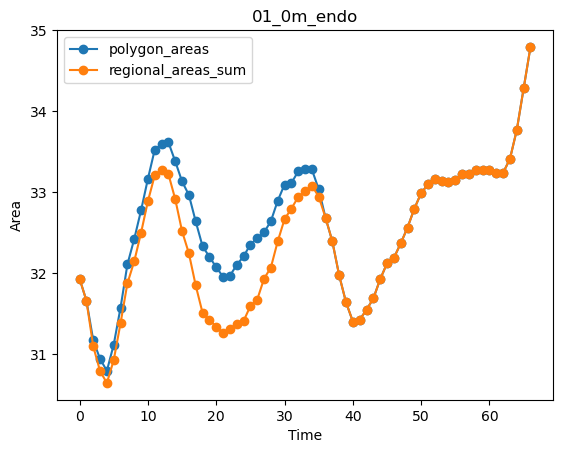

In [54]:
areas = [
    Polygon(np.concatenate([frame, [[0, 0]]])).area for frame in contour_points_time
]
plt.plot(areas, label="polygon_areas", marker="o", zorder=1)
plt.plot(
    np.sum(regional_areas_time, axis=1),
    label="regional_areas_sum",
    marker="o",
    zorder=2,
)
plt.xlabel("Time")
plt.ylabel("Area")
plt.legend()
plt.title(patient_info)

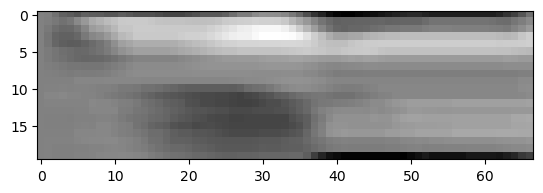

In [45]:
plt.imshow(regional_areas_time.T, cmap="gray")

In [48]:
local_es = np.argmin(regional_areas_time, axis=0)
print(local_es.shape)
regional_areas_time[(local_es, np.arange(len(local_es)))]

(20,)


array([0.73879273, 1.38555826, 1.39714632, 1.38914187, 1.35428647,
       1.43283913, 1.41990459, 1.51783759, 1.55727015, 1.59655894,
       1.36159579, 1.18111442, 1.17081005, 1.23122623, 1.1836741 ,
       1.20033938, 1.23249369, 1.31068323, 1.32362589, 0.74258123])

In [14]:
ids = []
for i, contour in enumerate(contours):
    if contour["patient_code"] == "05":
        print(i, contour["operation_status"], contour["wall_type"])
        ids.append(i)

16 0m endo
17 0m epi
18 6m endo
19 6m epi
20 np endo
21 np epi


In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as mpl_animation
from IPython import display

contour = contours[patient_n]
print(contour["coordinates"].shape)
figure, ax = plt.subplots()
x, y = contour["coordinates"][0].T
(line,) = plt.plot(x, y, marker="o", color="blue")
ax.set_aspect("equal")
ax.set_xlim(-6, 6)


def animate(j):
    x, y = contour["coordinates"][j].T
    line.set_xdata(x)
    line.set_ydata(y)
    return (line,)


animation = mpl_animation.FuncAnimation(
    figure, func=animate, frames=np.arange(0, len(contour["coordinates"])), interval=50
)
video_n = animation.to_html5_video()
html_code_n = display.HTML(video_n)
display.display(html_code_n)
plt.close()

(51, 49, 2)


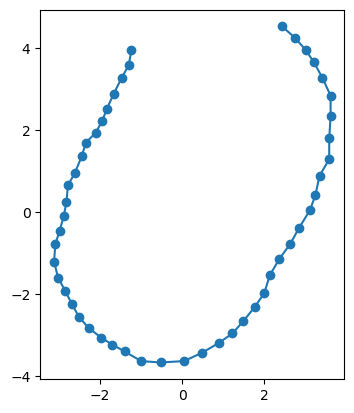

In [6]:
plt.plot(*contour["coordinates"][0].T, marker="o")
plt.gca().set_aspect("equal")

In [3]:
n = 96

frame = 10
contour_in_time = contours[n]["coordinates"]
contour = contour_in_time[frame]
contour_closed = np.r_[contour, contour[[0]]]
contour_poly = Polygon(contour)
print(
    contours[n]["patient_code"],
    contours[n]["operation_status"],
    contours[n]["wall_type"],
)

23 0m endo


In [30]:
ed_contour = contour_in_time[0]
center = np.mean(ed_contour, axis=0)
total_area = Polygon(np.r_[ed_contour, [[0, 0]]]).area
n_sectors = 20
part_area = total_area / n_sectors
print(total_area, part_area)

28.668550017842268 1.4334275008921133


28.668550017842264 28.668550017842268


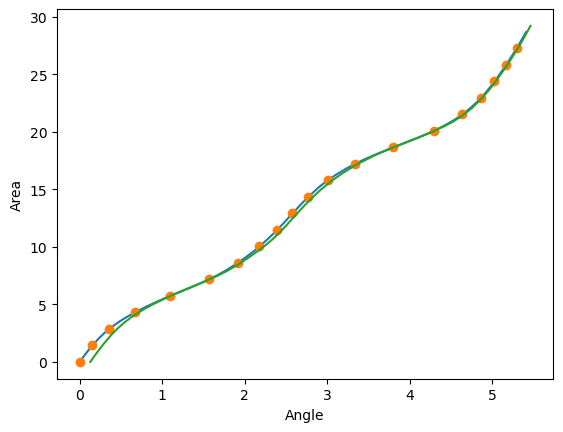

In [67]:
def car2pol(coords, center=None):
    if center is None:
        center = np.mean(coords, axis=0)
    coords_c = np.subtract(coords, center)
    r = np.linalg.norm(coords_c, axis=1)
    angle = np.arctan2(coords_c[:, 1], coords_c[:, 0])
    return r, angle


def make_contour_angle_increasing(angle):
    angle = np.array(angle)
    angle[np.where(angle < angle[0])] += 2 * np.pi
    return angle


r, phi = car2pol(ed_contour, [0, 0])

# plt.plot(phi)
phi_0 = phi[0]
phi = make_contour_angle_increasing(phi) - phi_0
# plt.plot(phi)

areas_tr = r[:-1] * r[1:] * np.sin(np.diff(phi)) / 2
areas_tr = np.array([0, *areas_tr])

print(np.sum(areas_tr), total_area)

plt.plot(phi, np.cumsum(areas_tr))
# plt.plot(np.cumsum(areas_tr), phi)
plt.xlabel("Angle")
plt.ylabel("Area")

import scipy.interpolate

angle_from_area_function = scipy.interpolate.interp1d(np.cumsum(areas_tr), phi)

sample_area_points = np.linspace(0, np.sum(areas_tr), n_sectors, endpoint=False)
sample_angles = angle_from_area_function(sample_area_points)
plt.plot(sample_angles, sample_area_points, linestyle="", marker="o")

r2, phi2 = car2pol(contour_in_time[10])
phi2 = make_contour_angle_increasing(phi2) - phi_0
areas_tr2 = r2[:-1] * r[1:] * np.sin(np.diff(phi2)) / 2
areas_tr2 = np.array([0, *areas_tr2])
plt.plot(phi2, np.cumsum(areas_tr2))

# areas_right = r[1:] ** 2 * np.diff(phi) / 2
# areas_left = r[:-1] ** 2 * np.diff(phi) / 2
# plt.plot(np.cumsum(areas_left), label='left')
# plt.plot(np.cumsum(areas_right), label='right')
# plt.legend()
# plt.plot(np.cumsum(areas_tr))
# print(total_area, np.sum(areas_left), np.sum(areas_right), np.sum(areas_tr))

In [57]:
dir(angle_from_area_function)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_call',
 '_call_linear',
 '_call_linear_np',
 '_call_nan_spline',
 '_call_nearest',
 '_call_previousnext',
 '_call_spline',
 '_check_and_update_bounds_error_for_extrapolation',
 '_check_bounds',
 '_evaluate',
 '_extrapolate',
 '_fill_value_above',
 '_fill_value_below',
 '_fill_value_orig',
 '_finish_y',
 '_kind',
 '_prepare_x',
 '_reshape_yi',
 '_set_dtype',
 '_set_yi',
 '_y',
 '_y_axis',
 '_y_extra_shape',
 'axis',
 'bounds_error',
 'copy',
 'dtype',
 'fill_value',
 'x',
 'y']

In [62]:
angle_from_area_function.fill_value

array(nan)

[[-1.57645213 -3.6593476 ]
 [ 0.83298152  4.3913349 ]]


Text(0.5, 1.0, '23_0m_endo frame=10')

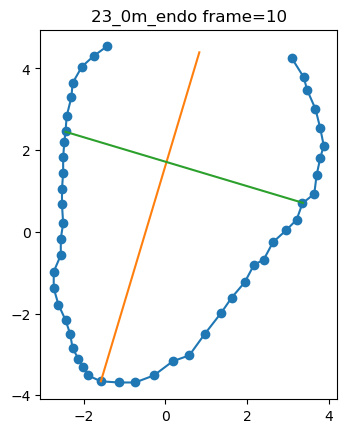

In [419]:
plt.plot(*contour.T, marker="o")
long_axis_line = get_long_axis(contour)
short_axis_line = get_short_axis(contour, long_axis_line)
print(long_axis_line)
# perpendicular
plt.plot(*long_axis_line.T)
plt.plot(*short_axis_line.T)
plt.gca().set_aspect("equal")
plt.title(
    f"{contours[n]['patient_code']}_{contours[n]['operation_status']}_{contours[n]['wall_type']} frame={frame}"
)

(array([4.45318916, 4.29987009, 4.10790137, 3.82754608, 3.60047488,
        3.30530633, 3.04504148, 2.93745882, 2.73717526, 2.61913463,
        2.53509167, 2.46509479, 2.40614498, 2.47108468, 2.58413874,
        2.76721897, 2.9300449 , 3.09946654, 3.22214789, 3.36557764,
        3.58012327, 3.68454911, 3.79919881, 3.96741829, 3.98447314,
        3.86143861, 3.76163709, 3.52604269, 3.25538796, 3.0490233 ,
        2.83219831, 2.59395741, 2.4438442 , 2.37241974, 2.35885443,
        2.40784283, 2.55738491, 2.74801486, 3.01166335, 3.25843493,
        3.50876697, 3.78508811, 4.05784372, 4.32292098, 4.48582472,
        4.61433907, 4.7814036 , 4.92864558, 5.12818617]),
 array([ 1.73766247,  1.82610548,  1.88969091,  1.97061735,  2.04190485,
         2.12860246,  2.21804926,  2.31067466,  2.42668904,  2.55577264,
         2.67929555,  2.84235605,  3.007068  , -3.13206005, -2.99798752,
        -2.87983877, -2.77056608, -2.64879655, -2.53326229, -2.43397225,
        -2.34374893, -2.24418939, -2.1

#### plt.plot(*contour.T, marker='o')
basal_midpoint = np.mean([contour[0], contour[-1]], axis=0)
long_axis_line = np.array([contour[4], basal_midpoint])
long_axis_vector = long_axis_line[1] - long_axis_line[0]
la_len = np.linalg.norm(long_axis_line)

short_point = long_axis_line[0] + long_axis_vector * 2 / 3
normal_to_la = np.array([1, -long_axis_vector[0]/long_axis_vector[1]])
normal_to_la = normal_to_la / np.linalg.norm(normal_to_la)

# la_normal_linestring = LineString(np.array([-1,0,1]) * normal_to_la[...,None])
la_normal_linestring = LineString(
    [short_point - normal_to_la * la_len, short_point, short_point + normal_to_la * la_len]
)
short_axis_linestring = la_normal_linestring.intersection(contour_poly)
short_axis_line = np.array(short_axis_linestring.xy).T[:,:2]
short_axis_vector = short_axis_line[1] - short_axis_line[0]
sa_len = np.linalg.norm(short_axis_vector)
print(la_len, sa_len)

# perpendicular
plt.plot(*long_axis_line.T)
plt.plot(*short_point, marker='o', markerfacecolor='red', markeredgecolor=(0,0,0,0))
plt.plot(*np.array([short_point, short_point + normal_to_la]).T)
plt.plot(*short_axis_line.T)
plt.gca().set_aspect('equal')

In [ ]:
from scipy.interpolate import splprep, splev


tck, u = splprep(contour_closed.T, s=0, per=True)
y = splev(np.linspace(0, 1, 52), tck)
y = np.array(y)
print(y.shape)

plt.plot(*contour.T, label="orig", marker="o")
plt.plot(*y, label="interpolation", marker="o", markersize=3)
plt.legend()
plt.gca().set_aspect("equal")

In [ ]:
from scipy.interpolate import splprep, splev

contour = contours[0]["coordinates"][0]
contour_closed = np.r_[contour, contour[[0]]]

tck, u = splprep(contour.T, s=0)
n = 6
y = splev(np.linspace(0, 1, 8 * n + 1), tck)
y_prime = splev(np.linspace(0, 1, 8 * n + 1), tck, der=1)
y = np.array(y)
print(y.shape)

x_prime = splev(u[4], tck, der=1)
x_prime2 = splev(u[4], tck, der=2)

x_c = contour[4][0] + x_prime[1] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (
    x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1]
)
y_c = contour[4][1] - x_prime[0] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (
    x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1]
)
k = (x_prime[0] * x_prime2[1] - x_prime2[0] * x_prime[1]) / (
    x_prime[0] ** 2 + x_prime[1] ** 2
) ** (3 / 2)
r = 1 / np.abs(k)

print(x_c, y_c, k, r)
plt.plot(*contour.T, label="orig", marker="o")
plt.plot(*y, label="interpolation", marker="o", markersize=3)
# plt.plot(x_c, y_c, color='red', marker='o')
circle = plt.Circle((x_c, y_c), radius=r, edgecolor="red", facecolor=(0, 0, 0, 0))
plt.gca().add_patch(circle)
plt.legend()
plt.gca().set_aspect("equal")

In [ ]:
from scipy.interpolate import splprep, splev

contour = contours[0]["coordinates"][0]
contour_closed = np.r_[contour, contour[[0]]]

tck, u = splprep(contour.T, s=0)
n = 5
y = splev(np.linspace(0, 1, 8 * n + 1), tck)
y_prime = splev(np.linspace(0, 1, 8 * n + 1), tck, der=1)
y = np.array(y)
print(y.shape)

x_prime = splev(u[4], tck, der=1)
x_prime2 = splev(u[4], tck, der=2)

x_c = contour[4][0] + x_prime[1] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (
    x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1]
)
y_c = contour[4][1] - x_prime[0] * (x_prime[0] ** 2 + x_prime[1] ** 2) / (
    x_prime[1] * x_prime2[0] - x_prime[0] * x_prime2[1]
)
k = (x_prime[0] * x_prime2[1] - x_prime2[0] * x_prime[1]) / (
    x_prime[0] ** 2 + x_prime[1] ** 2
) ** (3 / 2)
r = 1 / np.abs(k)

basal_midpoint = np.mean([contour[0], contour[-1]], axis=0)
plt.plot(*basal_midpoint, marker="o", color="green")

print(x_c, y_c, k, r)
plt.plot(*contour.T, label="orig", marker="o")
plt.plot(*y, label="interpolation", marker="o", markersize=3)
# plt.plot(x_c, y_c, color='red', marker='o')
circle = plt.Circle((x_c, y_c), radius=r, edgecolor="red", facecolor=(0, 0, 0, 0))
plt.gca().add_patch(circle)
plt.legend()
plt.gca().set_aspect("equal")

In [ ]:
def parabola(x, x_0, k, der=0):
    return x_0 + k * x**2


from scipy.optimize import curve_fit

xdata, ydata = contour[[3, 4, 5]].T
popt, pcov = curve_fit(parabola, xdata, ydata)

plt.plot(*contour.T, label="orig", marker="o")
xs = np.linspace(xdata[0], xdata[-1], 100, endpoint=True)
plt.plot(xs, parabola(xs, *popt))
plt.gca().set_aspect("equal")

In [ ]:
popt

In [ ]:
pcov